In [585]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from IPython.display import clear_output
from gpytorch.kernels.kernel import Kernel

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kf):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kf

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def plot_samples(self, x, n, data=False):
        self.eval()
        with torch.no_grad():
            samples = self(x).rsample(sample_shape=torch.Size([n, ]))
            for i in range(n):
                plt.plot(x.numpy(), samples[i].numpy())
            plt.show()
    
    def plot_post(self, xs, CI=False):
        self.eval()
        self.likelihood.eval()
        with torch.no_grad(), gpytorch.fast_pred_var():
            pred = self.likelihood(self(xs))
        with torch.no_grad():
            f, ax = plt.subplots(1, 1, figsize=(4, 3))
            ybar = self.train_targets.mean()
            ax.plot(self.train_inputs[0].numpy(),\
                    self.train_targets.numpy()+ybar.numpy(), 'k*')
            ax.plot(xs.numpy(), pred.mean.numpy()+ybar.numpy(), 'b')
            if(CI):
                lower = pred.mean+ybar - 1.96 * pred.variance ** 0.5
                upper = pred.mean+ybar + 1.96 * pred.variance ** 0.5
                ax.fill_between(xs.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
            ax.legend(['Observed Data', 'Mean'])
            plt.show()
    
    def train_model(self, iter, lr=0.5):
        self.train()
        self.likelihood.train()
        
        optimizer = torch.optim.Adam([
            {'params': self.parameters()},  # Includes GaussianLikelihood parameters
        ], lr=lr)
        
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(self.likelihood, self)
        training_iter = iter
        for i in range(training_iter):
            optimizer.zero_grad()
            output = self(self.train_inputs[0])
            loss = -mll(output, self.train_targets)
            loss.backward()
            clear_output(wait=True)
            print('Iter %d/%d' % (i + 1, training_iter))
            optimizer.step()
        print(loss.item())
        
class RQKernel(Kernel):
    def __init__(self, ard_num_dims=None, log_lengthscale_prior=None, eps=1e-6,\
                 active_dims=None, batch_size=1, log_alpha_prior=None):
        super(RQKernel, self).__init__(
            has_lengthscale=True,
            ard_num_dims=ard_num_dims,
            batch_size=batch_size,
            active_dims=active_dims,
            log_lengthscale_prior=log_lengthscale_prior,
            eps=eps,
        )
        self.register_parameter(
            name="log_alpha",
            parameter=torch.nn.Parameter(torch.zeros(batch_size, 1, 1)),
            prior=log_alpha_prior
        )
    def alpha(self):
        return self.log_alpha.exp()

    def forward(self, x1, x2, **params):
        alpha = self.alpha()
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)
        x1_, x2_ = self._create_input_grid(x1_, x2_, **params)

        diff = (x1_ - x2_).norm(2, dim=-1)
        return (1+diff.pow(2).div_(2*alpha)).pow(-alpha)


class OUKernel(Kernel):
    def __init__(self, ard_num_dims=None, log_lengthscale_prior=None,\
                 eps=1e-6, active_dims=None, batch_size=1):
        super(OUKernel, self).__init__(
            has_lengthscale=True,
            ard_num_dims=ard_num_dims,
            batch_size=batch_size,
            active_dims=active_dims,
            log_lengthscale_prior=log_lengthscale_prior,
            eps=eps,
        )
    def forward(self, x1, x2, **params):
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)
        x1_, x2_ = self._create_input_grid(x1_, x2_, **params)

        diff = (x1_ - x2_).norm(2, dim=-1)
        return diff.div(-2).exp_()
test_x = torch.linspace(1, 100, 100)
likelihood = gpytorch.likelihoods.GaussianLikelihood()


1. 
RBF: In the rbf model larger length scale corresponds to smoother processes and vice versa. The outputscale in rbf affects the variance of the process.

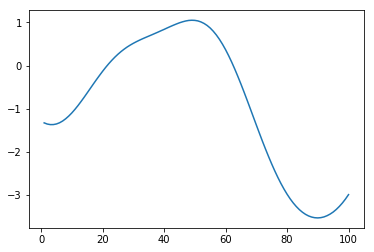

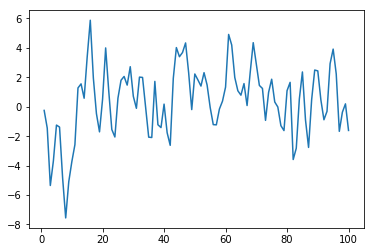

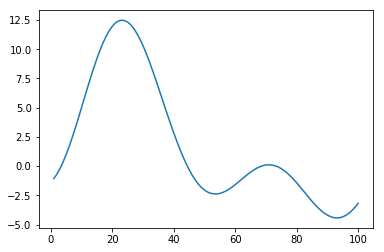

In [586]:
rbfkernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
rbfmodel = ExactGPModel(None, None, likelihood, rbfkernel)

rbfmodel.covar_module.log_outputscale.data[0] = math.log(5)
rbfmodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(20)
rbfmodel.plot_samples(test_x, 1)

rbfmodel.covar_module.log_outputscale.data[0] = math.log(5)
rbfmodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(1)
rbfmodel.plot_samples(test_x, 1)

rbfmodel.covar_module.log_outputscale.data[0] = math.log(100)
rbfmodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(20)
rbfmodel.plot_samples(test_x, 1)
plt.show()

Periodic: In the periodic kernel, clearly the period length controls the frequency.  The shorter the length scale, the less uniform it looks, as in the sample does not have the same peak and trough in every period.  Outputscale here controls the amplitude of the wave.

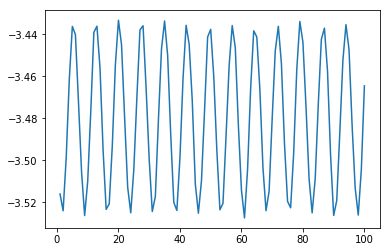

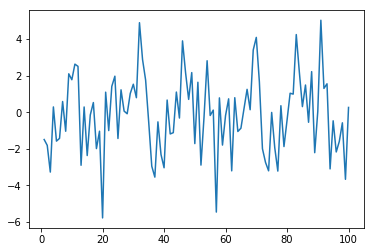

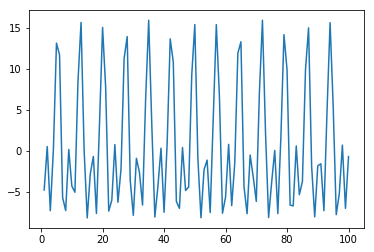

In [587]:
perkernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
permodel = ExactGPModel(None, None, likelihood, perkernel)


permodel.covar_module.log_outputscale.data[0] = math.log(5)
permodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(20)*2
permodel.covar_module.base_kernel.log_period_length.data[0,0,0] = 2
permodel.plot_samples(test_x, 1)

permodel.covar_module.log_outputscale.data[0] = math.log(5)
permodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(0.1)*2
permodel.covar_module.base_kernel.log_period_length.data[0,0,0] = 2
permodel.plot_samples(test_x, 1)

permodel.covar_module.log_outputscale.data[0] = math.log(100)
permodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(1)*2
permodel.covar_module.base_kernel.log_period_length.data[0,0,0] = 2
permodel.plot_samples(test_x, 1)

OU kernel: In ou kernel the lengthscale controls the step that each point can take.  With smaller lengthscale, the brownian motion is able to take bigger steps.  Outputscale again controls the variance.

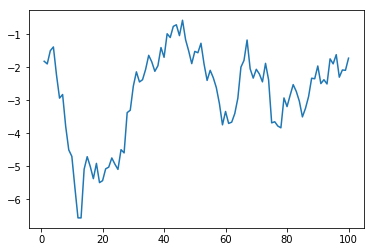

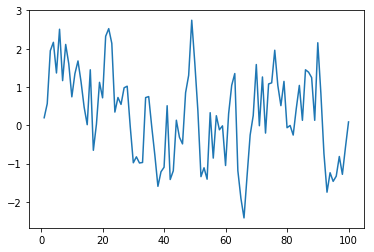

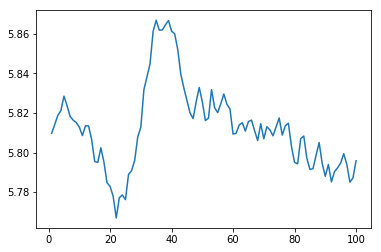

In [619]:
oukernel = gpytorch.kernels.ScaleKernel(OUKernel())
oumodel = ExactGPModel(None, None, likelihood, oukernel)

oumodel.covar_module.log_outputscale.data[0] = math.log(5)
oumodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(20)
oumodel.plot_samples(test_x, 1)

oumodel.covar_module.log_outputscale.data[0] = math.log(1)
oumodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(1)
oumodel.plot_samples(test_x, 1)

oumodel.covar_module.log_outputscale.data[0] = math.log(5)
oumodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(100000)
oumodel.plot_samples(test_x, 1)

RQ: Smaller alpha has the effect of generating process with higher frequency.  The length scale can also change the frequency but in different ways.

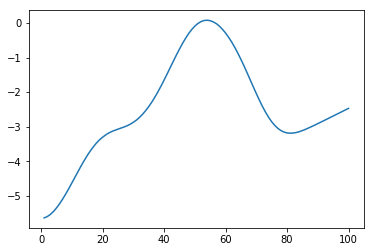

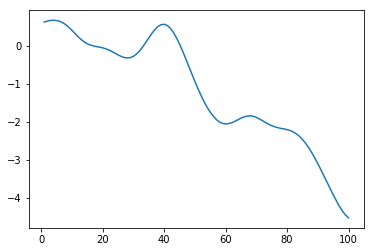

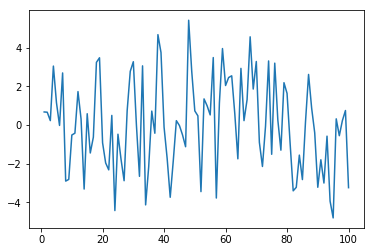

In [569]:
rqkernel = gpytorch.kernels.ScaleKernel(RQKernel())
rqmodel = ExactGPModel(None, None, likelihood, rqkernel)

rqmodel.covar_module.base_kernel.log_alpha.data[0,0,0] = math.log(2)
rqmodel.covar_module.log_outputscale.data[0] = math.log(5)
rqmodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(20)
rqmodel.plot_samples(test_x, 1)

rqmodel.covar_module.base_kernel.log_alpha.data[0,0,0] = math.log(0.6)
rqmodel.covar_module.log_outputscale.data[0] = math.log(5)
rqmodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(20)
rqmodel.plot_samples(test_x, 1)

rqmodel.covar_module.base_kernel.log_alpha.data[0,0,0] = math.log(10)
rqmodel.covar_module.log_outputscale.data[0] = math.log(5)
rqmodel.covar_module.base_kernel.log_lengthscale.data[0,0,0] = math.log(0.5)
rqmodel.plot_samples(test_x, 1)

b) general reasoning - the length scale l in the kernels can scale the size of the exponent.  With a small l, the exponent can become large even if the distance between x and x' is small, and since we are taking the negative of the exponent this will make the covariance very small even if x and x' are close.  This makes the process more noisy as covariance is small across the board, which leads to more oscilations and less smooth samples.  The function of the output scale is evident as letting x = x' we just have the variance.  Lastly, the alpha controls the weighing of the large scale and small scale variations as the QR kernel is a sum of RBF kernels with different length scales.  


2. 

In [544]:
def plot_post_samples(model, xs):
    model.eval()
    with torch.no_grad():
        samples = model(xs).rsample(sample_shape=torch.Size([2, ]))
        for i in range(2):
            plt.plot(x.numpy(), y.numpy()+ybar.numpy(), 'k*')
            plt.plot(xs.numpy(), samples[i].numpy()+ybar.numpy())
        plt.show()

In [594]:
import scipy.io as sio
import math
import numpy as np

data = sio.loadmat('data/datatest.mat')
x = data['x']
x = torch.tensor(x.T[0].tolist()).float()
y = data['y']
y = torch.tensor(y.T[0].tolist()).float()
ybar = y.mean()
y-=ybar

f = data['f']
xs = data['xstar']
xs = torch.tensor(xs.T[0].tolist())

a = y.std()
l = 5

likelihood.log_noise.data[0] = np.log(900) * 2

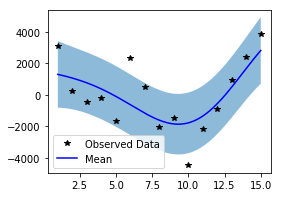

In [595]:
rbfkernel.log_outputscale[0] = torch.log(a) * 2
rbfkernel.base_kernel.log_lengthscale[0] = np.log(l)
rbfmodel = ExactGPModel(x, y, likelihood, rbfkernel)
rbfmodel.plot_post(xs, CI=True)

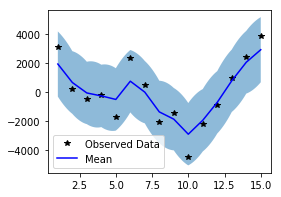

In [596]:
oukernel.log_outputscale[0] = torch.log(a) * 2
oukernel.base_kernel.log_lengthscale[0] = np.log(l)
oumodel = ExactGPModel(x, y, likelihood, oukernel)
oumodel.plot_post(xs, CI=True)

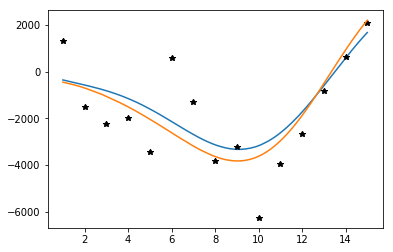

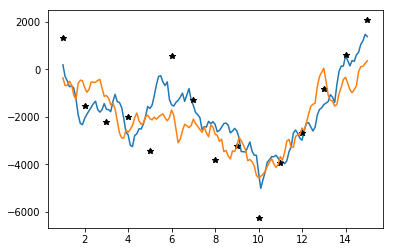

In [593]:
plot_post_samples(rbfmodel, xs)
plot_post_samples(oumodel, xs)

Question 3

In [93]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
rbfkernel3 = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
rbfmodel_post = ExactGPModel(x, y, likelihood, rbfkernel3)
rbfmodel_post.train_model(5000, 1.1)


Iter 5000/5000
9.724339485168457


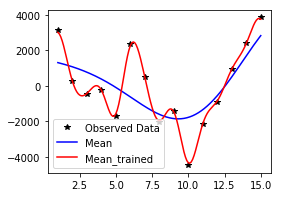

In [267]:
rbfmodel_post.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.fast_pred_var():
    rbfpost_pred = likelihood(rbfmodel_post(xs))

rbfmodel.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.fast_pred_var():
    rbf_pred = likelihood(rbfmodel(xs))
    
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ybar = y.mean()
    ax.plot(x.numpy(), y.numpy()+ ybar.numpy(), 'k*')
    ax.plot(xs.numpy(), rbf_pred.mean.numpy() + ybar.numpy(), 'b')
    ax.plot(xs.numpy(), rbfpost_pred.mean.numpy() + ybar.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.legend(['Observed Data', 'Mean', 'Mean_trained'])
    plt.show()

In [264]:
oukernel3 = gpytorch.kernels.ScaleKernel(OUKernel())
post_oumodel = ExactGPModel(x, y, likelihood, oukernel3)
post_oumodel.train_model(1000)


Iter 1000/1000
9.652348518371582


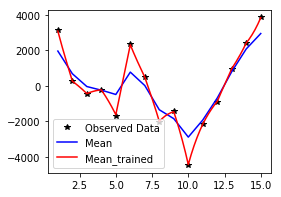

In [597]:
post_oumodel.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.fast_pred_var():
    post_ou_pred = likelihood(post_oumodel(xs))

rbfmodel.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.fast_pred_var():
    ou_pred = likelihood(oumodel(xs))
    
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ybar = y.mean()
    ax.plot(x.numpy(), y.numpy()+ ybar.numpy(), 'k*')
    ax.plot(xs.numpy(), ou_pred.mean.numpy() + ybar.numpy(), 'b')
    ax.plot(xs.numpy(), post_ou_pred.mean.numpy() + ybar.numpy(), 'r')
    # Shade between the lower and upper confidence bounds
    ax.legend(['Observed Data', 'Mean', 'Mean_trained'])
    plt.show()

a) The optimized parameters are tuned such that the negative marginal log likelihood is minimized.  This could mean overfitting so the mean of the posterior prediction reaches every training point.  The result from the previous part follows a more general pattern and tend to not touch all the training points.  

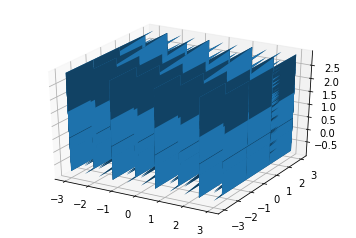

In [161]:
from mpl_toolkits import mplot3d
data2 = sio.loadmat('data/2dfunc.mat')
x2 = data2['x']
y2 = data2['y']

x21 = x2[:,0]
x22 = x2[:,1]

ax = plt.axes(projection='3d')
ax.plot_surface(x21,x22,y2)

x2 = torch.tensor(x2).float()
y2 = torch.tensor(y2.T[0].tolist()).float()


b) The GP with ARD kernel has smaller noise than the rbf model. The relative log likelihood between the two models at the optimized points is $\frac{0.746}{-0.11}\approx6.8$

In [604]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
ardkernel3b = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=2))

ardmodel = ExactGPModel(x2, y2, likelihood, ardkernel3b)
ardmodel.train_model(300)
print("noise", ardmodel.likelihood.log_noise.item())

Iter 300/300
0.43195608258247375
noise -8.950169563293457


In [602]:
rbfkernel3b = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
rbfmodel3b = ExactGPModel(x2, y2, likelihood, rbfkernel3b)
rbfmodel3b.train_model(100)
print("noise", rbfmodel3b.likelihood.log_noise.item())

Iter 100/100
-0.11085245758295059
noise -4.544190883636475


4.

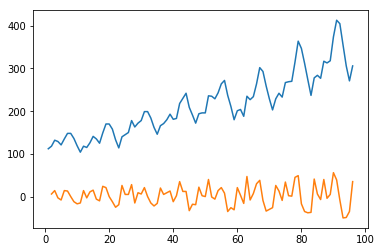

In [628]:
data3 = sio.loadmat('data/airline.mat')

x3_train = data3['xtrain'].T[0].astype(float)
y3_train = data3['ytrain'].T[0].astype(float)
x3_test = data3['xtest'].T[0].astype(float)
y3_test = data3['ytest'].T[0].astype(float)
full_x = np.concatenate((x3_train, x3_test))

plt.plot(x3_train, y3_train)
y3_diff = np.subtract(y3_train[1:], y3_train[:-1])
plt.plot(x3_train[1:], y3_diff)

x3_train = torch.tensor(x3_train).float()
y3_train = torch.tensor(y3_train).float()
x3_test = torch.tensor(x3_test).float()
y3_test = torch.tensor(y3_test).float()
x3_diff = x3_train[1:]
x3_diff_test = x3_test[1:]
y3_diff = torch.tensor(y3_diff).float()
y3_var = y3_diff.var()
ybar = y3_train.mean().float()
y3_train-=ybar
full_x = torch.tensor(full_x).float()


First I removed the overall trend by taking the difference.  This allows me to look at the periodicity as well as observe if there is any change in amplitude.  As we can see from the graph above, the variance of the seasonal process increases with respect to x, which is a property that we want to take into account when constructing the kernels.  The seasonality data is best fitted with a product of ou kernel and periodic kernel.  Adding a linear kernel to this we should be able to replicate the training data really well.  However, this model does not extrpolate well as the ou kernel can generate decay when we clearly see a rising trend, so the posterior mean is averaged out to be a smooth flat line.  This means that we need to explore kernels that can maintain the overall linear trend in extrapolation. 

In [609]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
kernel1 = gpytorch.kernels.LinearKernel(1)+\
gpytorch.kernels.ScaleKernel(OUKernel())*gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
model1 = ExactGPModel(x3_train, y3_train, likelihood, kernel1)
model1.train_model(200,0.5)

Iter 200/200
4.64556884765625


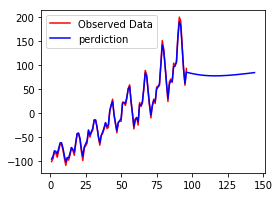

In [610]:
model1.eval()
model1.likelihood.eval()
with torch.no_grad(), gpytorch.fast_pred_var():
    pred = model1.likelihood(model1(full_x))
    
with torch.no_grad():
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ybar = model1.train_targets.mean()
    ax.plot(model1.train_inputs[0].numpy(), model1.train_targets.numpy()+ybar.numpy(), 'r')
    ax.plot(full_x.numpy(), pred.mean.numpy()+ybar.numpy(), 'b')
    ax.legend(['Observed Data', 'perdiction'])
    plt.show()

The product of a linear kernel and a periodic kernel is good at maintaining the trend in extrapolation.  While just a periodic kernel cannot model the seasonality as well as ou*periodic, in some convergence it approximates the oscillation relatively well.  Additionally, this model also allows increase in variance wrt x, as opposed to the sum of linear and periodic.  

In [752]:

class OUKernel2(Kernel):
    def __init__(self, ard_num_dims=None, log_lengthscale_prior=None,\
                 eps=1e-6, active_dims=None, batch_size=1, log_oscale_prior=None):
        super(OUKernel2, self).__init__(
            has_lengthscale=True,
            ard_num_dims=ard_num_dims,
            batch_size=batch_size,
            active_dims=active_dims,
            eps=eps,
        )
#         self.register_parameter(
#             name="log_oscale",
#             parameter=torch.nn.Parameter(torch.zeros(batch_size, 1, 1)),
#             prior=log_oscale_prior
#         )
        
    def oscale(self):
        return self.log_oscale.exp()

    def forward(self, x1, x2, **params):
        oscale = 20
        x1_ = x1.div(5)
        x2_ = x2.div(5)
        x1_, x2_ = self._create_input_grid(x1_, x2_, **params)

        diff = (x1_ - x2_).norm(2, dim=-1)
        return oscale*diff.div(-2).exp_()

class PeriodicKernel2(Kernel):
    def __init__(
        self, active_dims=None, batch_size=1, eps=1e-6, log_lengthscale_prior=None, log_period_length_prior=None
    ):
        super(PeriodicKernel2, self).__init__(
            has_lengthscale=True,
            active_dims=active_dims,
            batch_size=batch_size,
            log_lengthscale_prior=log_lengthscale_prior,
            eps=eps,
        )
#         self.register_parameter(
#             name="log_period_length",
#             parameter=torch.nn.Parameter(torch.zeros(batch_size, 1, 1)),
#             prior=log_period_length_prior,
#         )

    @property
    def period_length(self):
        return self.log_period_length.exp().clamp(self.eps, 1e5)

    def forward(self, x1, x2, **params):
        x1_ = x1.div(3.5/(2*math.pi))
        x2_ = x2.div(3.5/(2*math.pi))
        x1_, x2_ = self._create_input_grid(x1_, x2_, **params)

        diff = torch.sum((x1_ - x2_).abs(), -1)
        res = torch.sin(diff.mul(math.pi)).pow(2).mul(-2 / self.lengthscale).exp_()
        if diff.ndimension() == 2:
            res = res.squeeze(0)
        return res

In [765]:
kernel2 = gpytorch.kernels.ScaleKernel(OUKernel())+gpytorch.kernels.LinearKernel(1)*\
gpytorch.kernels.ScaleKernel(PeriodicKernel2())

model2 = ExactGPModel(x3_train, y3_train, likelihood, kernel2)
model2.train_model(200,0.2)


Iter 200/200
4.6853742599487305


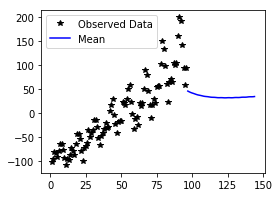

In [769]:
model2.plot_post(x3_test)
